In [1]:
##스타트업 파일

from scipy.stats import norm
import numpy as np
import scipy as sp
from pandas.core import datetools 
import pandas as pd
import statsmodels.api as sm ## R 패키지에서 불러온것, 샘플데이터 옮겨쓸수 있는 프로젝트 있음. 회귀분석에 유용 
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk 
## 전처리 

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pylab 
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()



C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  


## EDA(Exploratory Data Analysis)

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.tail() ## 26729 rows * 10 features

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26724,A702446,NaN,2015-05-14 11:56,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White
26725,A718934,NaN,2016-01-20 18:59,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby
26726,A698128,Zeus,2015-03-09 13:33,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 9:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [4]:
train.describe() ## feature 별로 분류된 outcome 다름

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
count,26729,19038,26729,26729,13117,26729,26728,26711,26729,26729
unique,26729,6374,22918,5,16,2,5,44,1380,366
top,A679970,Max,2015-08-11 0:00,Adoption,Partner,Dog,Neutered Male,1 year,Domestic Shorthair Mix,Black/White
freq,1,136,19,10769,7816,15595,9779,3969,8810,2824


In [5]:
train.groupby("AnimalType").count() ## Cats = 11134, Dogs = 15595

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,SexuponOutcome,AgeuponOutcome,Breed,Color
AnimalType,,,,,,,,,
Cat,11134,6115,11134,11134,7511,11134,11117,11134,11134
Dog,15595,12923,15595,15595,5606,15594,15594,15595,15595


AnimalType
Cat    11134
Dog    15595
dtype: int64

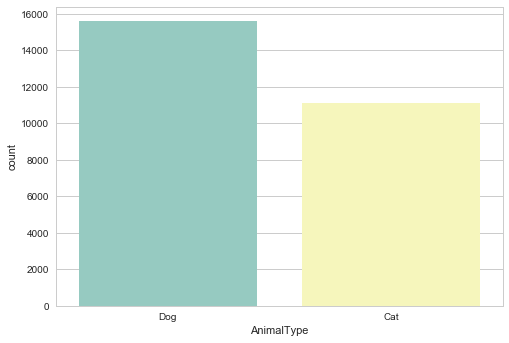

In [6]:
sns.countplot(train.AnimalType, palette='Set3')
train.groupby('AnimalType').size()

OutcomeType
Adoption           10769
Died                 197
Euthanasia          1555
Return_to_owner     4786
Transfer            9422
Name: AnimalID, dtype: int64

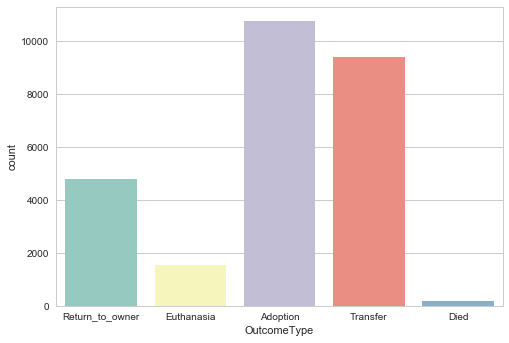

In [7]:
sns.countplot(train.OutcomeType, palette='Set3')
train.groupby("OutcomeType").count()['AnimalID']

SexuponOutcome
Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
dtype: int64

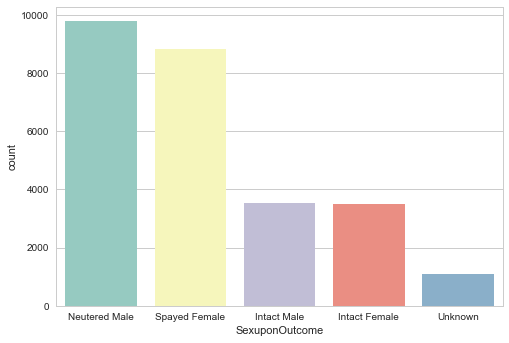

In [8]:
sns.countplot(train.SexuponOutcome, palette='Set3')
train.groupby('SexuponOutcome').size().sort_values(ascending = False)

In [9]:
def sex(x):
    x = str(x)
    if x.find("Male") >=0: return 'Male'
    if x.find("Female") >=0 : return 'Female'
    return 'Female' ## Imputing: Nan값: 겉으로 중성화가 되었는지 확인이 불가능한 경우는 Female
def neutered(x):
    x = str(x)
    if x.find('Spayed')>=0: return 'Neutered'
    if x.find('Neutered')>=0: return 'Neutered'
    if x.find('Intact')>=0: return'Intact'
    return 'Intact' ## imputing: 겉으로 중성화가 되었는지 확인이 불가능한 경우는 Intact Female

In [10]:
train['Sex'] = train.SexuponOutcome.apply(sex)
train['Neutered'] = train.SexuponOutcome.apply(neutered)    

Sex
Female    13425
Male      13304
dtype: int64


Neutered
Intact       8130
Neutered    18599
dtype: int64

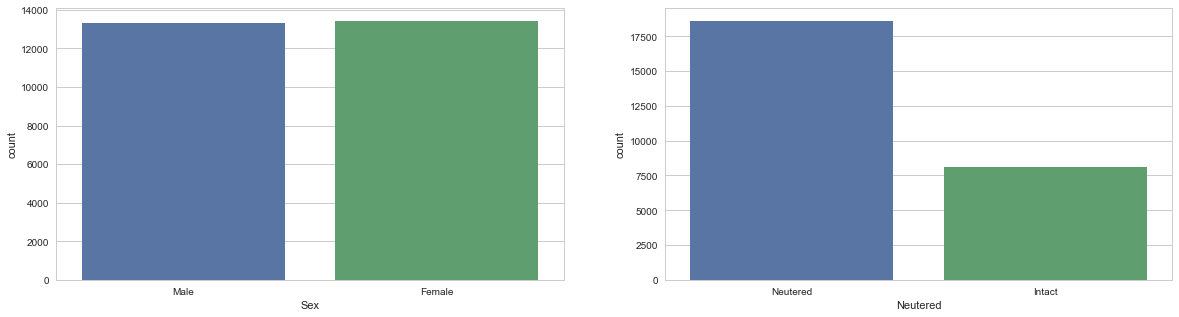

In [11]:
f,(ax1,ax2) = plt.subplots(1,2, figsize=(20,5))
sns.countplot(train.Sex,ax =ax1)
sns.countplot(train.Neutered,ax =ax2)
print(train.groupby('Sex').size())
train.groupby('Neutered').size()

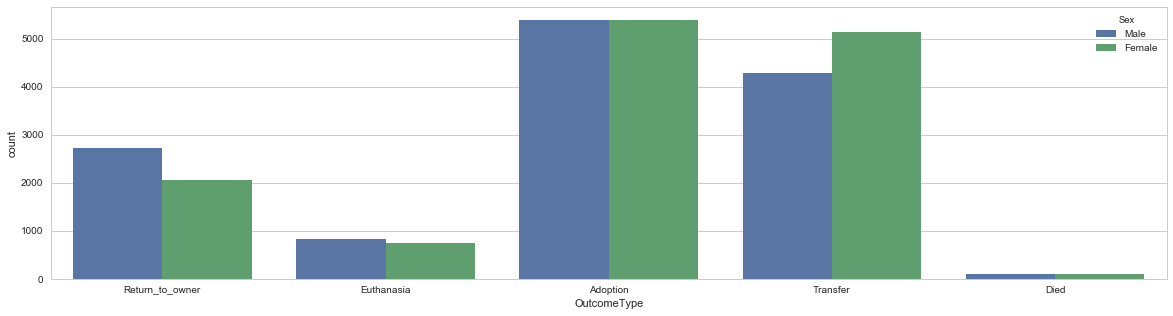

In [12]:
f,(ax1) = plt.subplots(1,figsize=(20,5))
sns.countplot(data=train, x ='OutcomeType',hue='Sex',ax=ax1)


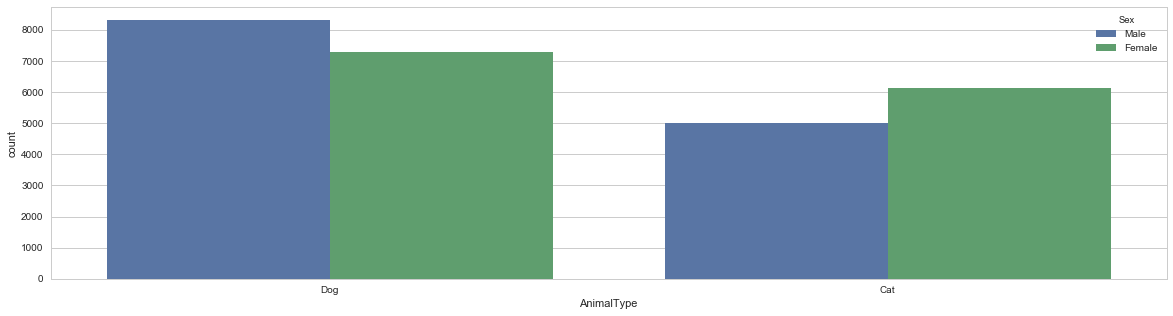

In [13]:
f,(ax1) = plt.subplots(1,figsize=(20,5))
sns.countplot(data=train, x ='AnimalType',hue='Sex',ax=ax1)


## NAN 값 확인후 Imputing 

In [14]:
## Nan 값 확인 
train.isnull().any()

AnimalID          False
Name               True
DateTime          False
OutcomeType       False
OutcomeSubtype     True
AnimalType        False
SexuponOutcome     True
AgeuponOutcome     True
Breed             False
Color             False
Sex               False
Neutered          False
dtype: bool

In [15]:
np.where(train['SexuponOutcome'].isnull()) ## 3174번 샘플 Nan값 확인 

(array([3174], dtype=int64),)

In [16]:
## Imputer 
def Seximputer(x):
    x = str(x)
    if x.lower() == 'nan': return 'Neutered Male'
    else: return x

In [17]:
train['SexuponOutcome'] = train['SexuponOutcome'].apply(Seximputer)

In [18]:
np.where(train['AgeuponOutcome'].isnull())

(array([ 2480,  2912,  3766,  3875,  4498,  5137,  5691,  7005,  8420,
        17464, 18490, 19927, 21523, 22380, 22448, 24328, 26551, 26570], dtype=int64),)

In [19]:
def Ageimputer(x):
    x = str(x)
    if x.lower() == 'nan': return '2 years' #int(np.mean(train['AgeInYears']))
    else: return x
    

In [20]:
train['AgeuponOutcome'] = train['AgeuponOutcome'].apply(Ageimputer)
np.where(train['AgeuponOutcome'].isnull())

(array([], dtype=int64),)

In [21]:
train.loc[22911]

AnimalID                         A710575
Name                                 NaN
DateTime                2015-08-24 18:56
OutcomeType                     Transfer
OutcomeSubtype                   Partner
AnimalType                           Cat
SexuponOutcome                   Unknown
AgeuponOutcome                   0 years
Breed             Domestic Shorthair Mix
Color                 Orange Tabby/White
Sex                               Female
Neutered                          Intact
Name: 22911, dtype: object

In [22]:
def calc_age_in_years(x):
    x = str(x)
    age = int(x.split()[0])
    if x.find('year') > -1: 
        if age ==0: return 0.1 ## 0 years 로 표시 되어있는 동물들 22 마리 0.1로 변환 
        else: return age
    if x.find('month')> -1:
        if age <=6: return 0.5 ## 6개월미만 float 0.5로 변환 
        else:
            return 1
    if x.find('week')> -1: return 0.1#float('{:.1f}'.format(int(x.split()[0])/52)) ## float 0.1 로 변형 
    if x.find('day')> -1: return 0.1 #float('{:.1f}'.format(int(x.split()[0])/52)) ## float 0.1 로 변형
    else: return np.mean(x)


In [23]:
train['AgeInYears'] = train['AgeuponOutcome'].apply(calc_age_in_years)

In [24]:
np.where(train['AgeInYears']==0.0) ## 0살 샘플 확인 필요 0 years ## 대부분 Transfer, some are Euthanasia or Died

(array([], dtype=int64),)

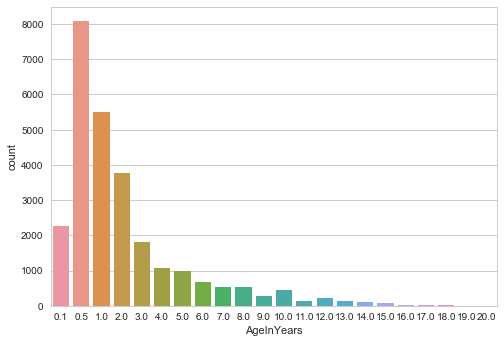

In [25]:

sns.countplot(train.AgeInYears)


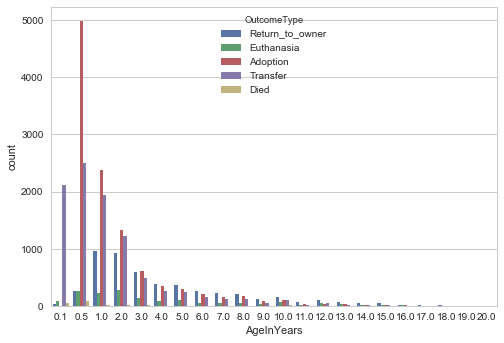

In [26]:
sns.countplot(data=train, x='AgeInYears',hue='OutcomeType')## 결과에 따른 나이

In [27]:
def calc_age_category(x):
    
    if x < 0.5: return 'baby'
    elif x < 1: return 'cubs'
    elif x < 5: return 'young adult'
    elif x < 10: return 'adult'
    return 'old'
train['AgeCategory'] = train.AgeInYears.apply(calc_age_category)


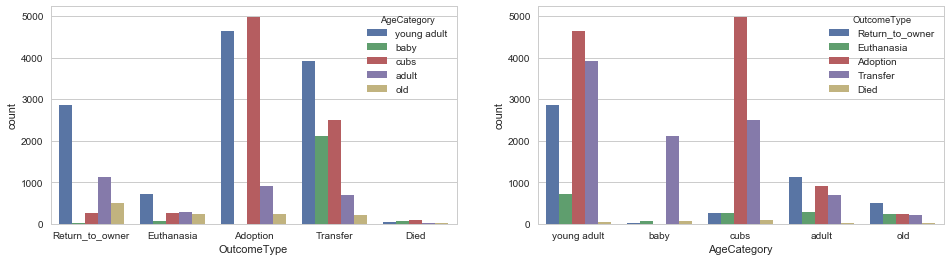

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train, x='OutcomeType',hue='AgeCategory', ax=ax1)## 결과에 따른 나이
sns.countplot(data=train, x='AgeCategory',hue='OutcomeType', ax=ax2)## 나이에 따른 결과 


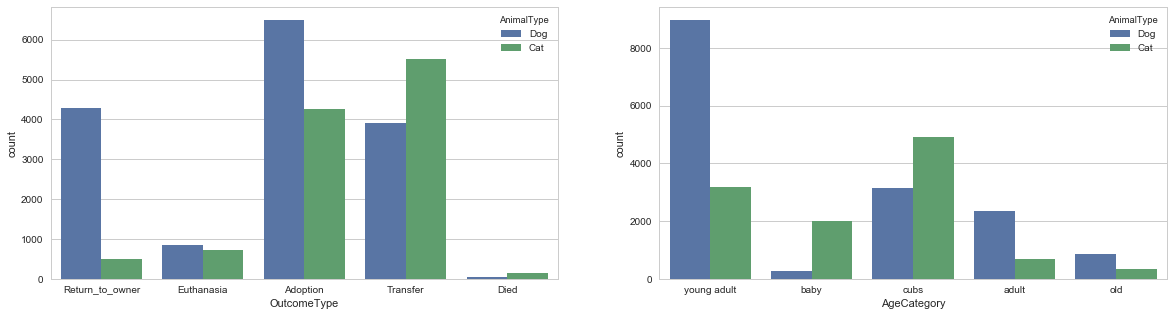

In [29]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=train, x ='OutcomeType',hue='AnimalType',ax=ax1)
sns.countplot(data=train, x='AgeCategory',hue='AnimalType', ax=ax2)## 나이에 따른 Animal Type  


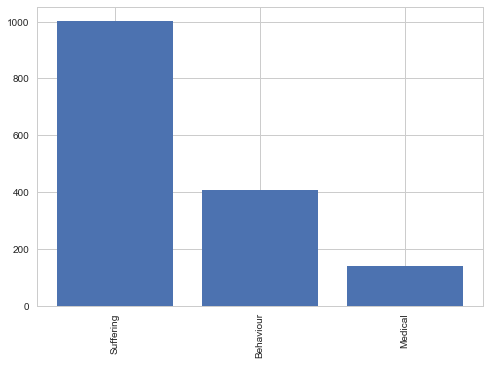

In [30]:
## 안락사의 경우 subtype 이유 
## 1. 고통, 지병
## 2. 공격적인 성향 또는 행동문제
## 3. 광견병 또는 전염병의 Medical 의 이유 

euthanasia = train[train["OutcomeType"] == "Euthanasia"] 
subtype = euthanasia["OutcomeSubtype"].value_counts()

suffering = subtype["Suffering"]
behaviour = subtype["Aggressive"] +subtype["Behavior"]
medical = subtype["Rabies Risk"] + subtype["Medical"] 



subtype_list = [suffering,behaviour,medical]
list_names = ["Suffering","Behaviour","Medical"]
ind2 = np.arange(len(subtype_list))

plt.bar(ind2,subtype_list)
plt.xticks(ind2,list_names, rotation = 90)
plt.show()

## Feature Values Category 분류 

### Dog Breeds 나누기 

In [31]:
group = train.groupby(['OutcomeType','Breed'])
group.size().sort_values(ascending = False)

OutcomeType      Breed                                    
Transfer         Domestic Shorthair Mix                       4538
Adoption         Domestic Shorthair Mix                       3273
                 Chihuahua Shorthair Mix                       767
Return_to_owner  Pit Bull Mix                                  598
Adoption         Labrador Retriever Mix                        590
                 Pit Bull Mix                                  568
Euthanasia       Domestic Shorthair Mix                        535
Transfer         Chihuahua Shorthair Mix                       501
                 Pit Bull Mix                                  478
Return_to_owner  Chihuahua Shorthair Mix                       407
Transfer         Domestic Medium Hair Mix                      383
Return_to_owner  Labrador Retriever Mix                        369
Adoption         Domestic Medium Hair Mix                      357
Return_to_owner  Domestic Shorthair Mix                        352
Tra

In [32]:
## Animal Type = Dog 인것중에 개 Breed 로 나눠 인덱싱, 총 15595 rows 
feature = 'Breed'

feature_values_dog = train.loc[train['AnimalType'] == 'Dog',feature]
group = train.groupby([feature_values_dog])
group.size().sort_values(ascending = False) 

Breed
Pit Bull Mix                              1906
Chihuahua Shorthair Mix                   1766
Labrador Retriever Mix                    1363
German Shepherd Mix                        575
Australian Cattle Dog Mix                  367
Dachshund Mix                              318
Boxer Mix                                  245
Miniature Poodle Mix                       233
Border Collie Mix                          229
Australian Shepherd Mix                    163
Rat Terrier Mix                            157
Catahoula Mix                              157
Jack Russell Terrier Mix                   146
Yorkshire Terrier Mix                      143
Chihuahua Longhair Mix                     142
Siberian Husky Mix                         138
Miniature Schnauzer Mix                    136
Beagle Mix                                 124
Rottweiler Mix                             113
American Bulldog Mix                       109
Cairn Terrier Mix                          102
Shih Tz

In [33]:
## 206 가지의 개분류를 7type의 group으로 매치 ## 총 206가지 
breeds = ['Blue Lacy','Queensland Heeler','Rhod Ridgeback','Retriever','Chinese Sharpei','Black Mouth Cur','Catahoula','Staffordshire','Affenpinscher','Afghan Hound','Airedale Terrier','Akita','Australian Kelpie','Alaskan Malamute','English Bulldog','American Bulldog','American English Coonhound','American Eskimo Dog (Miniature)','American Eskimo Dog (Standard)','American Eskimo Dog (Toy)','American Foxhound','American Hairless Terrier','American Staffordshire Terrier','American Water Spaniel','Anatolian Shepherd Dog','Australian Cattle Dog','Australian Shepherd','Australian Terrier','Basenji','Basset Hound','Beagle','Bearded Collie','Beauceron','Bedlington Terrier','Belgian Malinois','Belgian Sheepdog','Belgian Tervuren','Bergamasco','Berger Picard','Bernese Mountain Dog','Bichon Fris_','Black and Tan Coonhound','Black Russian Terrier','Bloodhound','Bluetick Coonhound','Boerboel','Border Collie','Border Terrier','Borzoi','Boston Terrier','Bouvier des Flandres','Boxer','Boykin Spaniel','Briard','Brittany','Brussels Griffon','Bull Terrier','Bull Terrier (Miniature)','Bulldog','Bullmastiff','Cairn Terrier','Canaan Dog','Cane Corso','Cardigan Welsh Corgi','Cavalier King Charles Spaniel','Cesky Terrier','Chesapeake Bay Retriever','Chihuahua','Chinese Crested Dog','Chinese Shar Pei','Chinook','Chow Chow',"Cirneco dell'Etna",'Clumber Spaniel','Cocker Spaniel','Collie','Coton de Tulear','Curly-Coated Retriever','Dachshund','Dalmatian','Dandie Dinmont Terrier','Doberman Pinsch','Doberman Pinscher','Dogue De Bordeaux','English Cocker Spaniel','English Foxhound','English Setter','English Springer Spaniel','English Toy Spaniel','Entlebucher Mountain Dog','Field Spaniel','Finnish Lapphund','Finnish Spitz','Flat-Coated Retriever','French Bulldog','German Pinscher','German Shepherd','German Shorthaired Pointer','German Wirehaired Pointer','Giant Schnauzer','Glen of Imaal Terrier','Golden Retriever','Gordon Setter','Great Dane','Great Pyrenees','Greater Swiss Mountain Dog','Greyhound','Harrier','Havanese','Ibizan Hound','Icelandic Sheepdog','Irish Red and White Setter','Irish Setter','Irish Terrier','Irish Water Spaniel','Irish Wolfhound','Italian Greyhound','Japanese Chin','Keeshond','Kerry Blue Terrier','Komondor','Kuvasz','Labrador Retriever','Lagotto Romagnolo','Lakeland Terrier','Leonberger','Lhasa Apso','L_wchen','Maltese','Manchester Terrier','Mastiff','Miniature American Shepherd','Miniature Bull Terrier','Miniature Pinscher','Miniature Schnauzer','Neapolitan Mastiff','Newfoundland','Norfolk Terrier','Norwegian Buhund','Norwegian Elkhound','Norwegian Lundehund','Norwich Terrier','Nova Scotia Duck Tolling Retriever','Old English Sheepdog','Otterhound','Papillon','Parson Russell Terrier','Pekingese','Pembroke Welsh Corgi','Petit Basset Griffon Vend_en','Pharaoh Hound','Plott','Pointer','Polish Lowland Sheepdog','Pomeranian','Standard Poodle','Miniature Poodle','Toy Poodle','Portuguese Podengo Pequeno','Portuguese Water Dog','Pug','Puli','Pyrenean Shepherd','Rat Terrier','Redbone Coonhound','Rhodesian Ridgeback','Rottweiler','Russell Terrier','St. Bernard','Saluki','Samoyed','Schipperke','Scottish Deerhound','Scottish Terrier','Sealyham Terrier','Shetland Sheepdog','Shiba Inu','Shih Tzu','Siberian Husky','Silky Terrier','Skye Terrier','Sloughi','Smooth Fox Terrier','Soft-Coated Wheaten Terrier','Spanish Water Dog','Spinone Italiano','Staffordshire Bull Terrier','Standard Schnauzer','Sussex Spaniel','Swedish Vallhund','Tibetan Mastiff','Tibetan Spaniel','Tibetan Terrier','Toy Fox Terrier','Treeing Walker Coonhound','Vizsla','Weimaraner','Welsh Springer Spaniel','Welsh Terrier','West Highland White Terrier','Whippet','Wire Fox Terrier','Wirehaired Pointing Griffon','Wirehaired Vizsla','Xoloitzcuintli','Yorkshire Terrier']
groups = ['Herding','Herding','Hound','Sporting','Non-Sporting','Herding','Herding','Terrier','Toy','Hound','Terrier','Working','Working','Working','Non-Sporting','Non-Sporting','Hound','Non-Sporting','Non-Sporting','Toy','Hound','Terrier','Terrier','Sporting','Working','Herding','Herding','Terrier','Hound','Hound','Hound','Herding','Herding','Terrier','Herding','Herding','Herding','Herding','Herding','Working','Non-Sporting','Hound','Working','Hound','Hound','Working','Herding','Terrier','Hound','Non-Sporting','Herding','Working','Sporting','Herding','Sporting','Toy','Terrier','Terrier','Non-Sporting','Working','Terrier','Working','Working','Herding','Toy','Terrier','Sporting','Toy','Toy','Non-Sporting','Working','Non-Sporting','Hound','Sporting','Sporting','Herding','Non-Sporting','Sporting','Hound','Non-Sporting','Terrier','Working','Working','Working','Sporting','Hound','Sporting','Sporting','Toy','Herding','Sporting','Herding','Non-Sporting','Sporting','Non-Sporting','Working','Herding','Sporting','Sporting','Working','Terrier','Sporting','Sporting','Working','Working','Working','Hound','Hound','Toy','Hound','Herding','Sporting','Sporting','Terrier','Sporting','Hound','Toy','Toy','Non-Sporting','Terrier','Working','Working','Sporting','Sporting','Terrier','Working','Non-Sporting','Non-Sporting','Toy','Terrier','Working','Herding','Terrier','Toy','Terrier','Working','Working','Terrier','Herding','Hound','Non-Sporting','Terrier','Sporting','Herding','Hound','Toy','Terrier','Toy','Herding','Hound','Hound','Hound','Sporting','Herding','Toy','Non-Sporting','Non-Sporting','Toy','Hound','Working','Toy','Herding','Herding','Terrier','Hound','Hound','Working','Terrier','Working','Hound','Working','Non-Sporting','Hound','Terrier','Terrier','Herding','Non-Sporting','Toy','Working','Toy','Terrier','Hound','Terrier','Terrier','Herding','Sporting','Terrier','Working','Sporting','Herding','Working','Non-Sporting','Non-Sporting','Toy','Hound','Sporting','Sporting','Sporting','Terrier','Terrier','Hound','Terrier','Sporting','Sporting','Non-Sporting','Toy']
#breeds_group = np.array([breeds,groups]).T

df = pd.DataFrame([breeds,groups]).T ## 데이터 프레임으로 매치 시킴 

#df.groupby([1]).groups
df.groupby([1]).size()
#df[1] == 'Herding','breeds'
#feature_values_dog = train.loc[train['AnimalType'] == 'Dog',feature]

#df.sort_values(by=1)[0].values
# len(Herding+Hound+Non_Sporting+Sporting+Terrier+Toy +Working) = 206 

1
Herding         32
Hound           31
Non-Sporting    25
Sporting        31
Terrier         33
Toy             21
Working         33
dtype: int64

In [34]:
## 고양이 종류 총 60여가지, 크게 나누면 훨씬 쉬움
## 약 80프로 이상의 고양이가 5가지 이내의 카테고리 분류로 들어감 
feature_values_cat = train.loc[train['AnimalType'] == 'Cat',feature]
feature_values_cat
group = train.groupby([feature_values_cat])
group.size().sort_values(ascending = False) 

Breed
Domestic Shorthair Mix                     8810
Domestic Medium Hair Mix                    839
Domestic Longhair Mix                       520
Siamese Mix                                 389
Domestic Shorthair                          143
Snowshoe Mix                                 75
Manx Mix                                     44
Maine Coon Mix                               44
Domestic Medium Hair                         42
Russian Blue Mix                             33
Siamese                                      24
Domestic Longhair                            23
Himalayan Mix                                15
Persian Mix                                  12
Ragdoll Mix                                  11
Siamese/Domestic Shorthair                   11
American Shorthair Mix                        9
Angora Mix                                    7
Japanese Bobtail Mix                          6
Bombay Mix                                    5
Balinese Mix                      

In [35]:
def Mix(x): ## Mix 인지 아닌지 구분 (개, 고양이 모두 포함 )
    x =str(x)
    if x.lower == 'nan'or '': return 'Unknown'
    if x.find('Mix')>-1:return 'Mix'
    elif x.find('/')>-1:return 'Mix'
    else:
        return 'Pure Breed'

In [36]:
train['Mix'] = train.Breed.apply(Mix) ## Mix column 만듬 (나중에 필요시 삭제)
#train['Mix']
#sns.countplot(data=train, x ='Mix')

In [37]:
train[['Breed','Mix']]

,Breed,Mix
0,Shetland Sheepdog Mix,Mix
1,Domestic Shorthair Mix,Mix
2,Pit Bull Mix,Mix
3,Domestic Shorthair Mix,Mix
4,Lhasa Apso/Miniature Poodle,Mix
5,Cairn Terrier/Chihuahua Shorthair,Mix
6,Domestic Shorthair Mix,Mix
7,Domestic Shorthair Mix,Mix
8,American Pit Bull Terrier Mix,Mix
9,Cairn Terrier,Pure Breed


## Dog's type 총 10 category(위키피디아 참조)

In [38]:
## Dog's type 총 10 category

## 목양견, 양치기견
Herding = ['Bearded Collie', 'Beauceron', 'Belgian Malinois','Malinois','Anatol','Anatol Shepherd',
       'Belgian Sheepdog', 'Belgian Tervuren', 'Bergamasco','Kelpie/Pit','Kelpie/Finnish',
       'Berger Picard', 'Shetland Sheepdog', 'Border Collie','Border Collie/Greyhound', 'Briard',
       'Pyrenean Shepherd', 'Puli', 'Polish Lowland Sheepdog','Border','Collie/Rottweiler',
       'Cardigan Welsh Corgi','Cardigan', 'Pembroke Welsh Corgi','Welsh','Corgi/Brittany','Border Collie/Rottweiler',
       'Old English Sheepdog', 'Collie', 'Norwegian Buhund','Pointer/Collie Smooth','Pointer/Collie',
       'Miniature American Shepherd', 'Entlebucher Mountain Dog','Belgian Malinois','Dutch','Dutch Shepherd'
       'Finnish Lapphund', 'Gefrman Shepherd', 'Icelandic Sheepdog','Catahoula/Pit',
       'Spanish Water Dog', 'Australian Shepherd Mix', 'Australian Shepherd','Bouvier des Flandres',
       'Queensland Heeler','Heeler', 'Swedish Vallhund','Swedish Vallhund Mix','Vallhund', 'Australian Cattle Dog',
        'Black Mouth Cur','Mouth','Catahoula', 'Anatolian Shepherd Dog',
        'Collie','Sheepdog','Corgi','Mountain','Cattle','Water Dog']
Australian_Shepherd = ['Australian Shepherd Mix','Australian Shepherd','Australian Shepherd/Anatol Shepherd']

## 사냥견
Hound = ['Greyhound','Basset', 'Hound','Saluki','Rhodesian Ridgeback','Redbone Coonhound','Treeing','Treeing Walker Coonhound',
         'Treeing Walker Coonhound Mix','Beagle/Pointer','Beagle/Staffordshire','Portuguese Podengo Pequeno','Podengo Pequeno Mix',
         'Podengo','Plott','Norwegian Elkhound','Pharaoh Hound','Petit Basset Griffon Vend_en','Pug/Beagle','Beagle/Pug',
         'Afghan Hound','Otterhound','Whippet','Borzoi','English Foxhound','Irish Wolfhound','Wolfhound','Basenji','Basset Hound',
         'Boxer/Beagle','Beagle','Beagle/Treeing','Harrier','Harrier/Catahoula','Sloughi','Ibizan Hound','American Foxhound','Foxhound',
         'Rhod Ridgeback','Rhod ','Ridgeback','Rhod/Ridgeback','Black and Tan Coonhound','Beagle/Chihuahua','Pbgv','Boxer/Harrier',
         'American English Coonhound','Coonhound','Bloodhound','Bluetick Coonhound','Scottish Deerhound','Plott Hound',
         "Cirneco dell'Etna",'Pit Bull/Dogue De Bordeaux','Carolina','De','Bordeaux','Basenji/Chihuahua']

## 실내견,가정견,애완견 Companian dogs
Non_Sporting = ['Finnish','French Bulldog','Keeshond','Dalmatian','Dalmatian/Boxer','Sharpei','Chinese Sharpei','Chinese Sharpei Mix','Coton de Tulear',
 'Lhasa Apso','Lhasa', 'Apso','Norwegian Lundehund','L_wchen','Xoloitzcuintli','Schipperke','Schipperke/Chihuahua','American Bulldog','Bulldog/Pointer',
 'English Bulldog','Bichon Fris','Bichon Frise Mix','Bichon','Bulldog','Standard Poodle','Eskimo','Tibetan Spaniel','Bulldog/Chihuahua',
 'Chinese Shar Pei','Miniature Poodle','Shiba Inu','Mexican Hairless Mix','Crested']
## 스포츠견, 활동적, 야외활동
Sporting = ['Greyhound/Dalmatian','Irish Red and White Setter','Irish Setter','Setter/Pit','Sussex Spaniel','Nova Scotia Duck Tolling Retriever','Irish Water Spaniel',
 'Labrador Retriever','Retriever/Whippet','Labrador','Lagotto Romagnolo','Vizsla','Vizsla Mix','Vizsla/Boxer','Vizsla/Staffordshire',
 'Vizsla/Rhod Ridgeback', 'Vizsla/Catahoula','Weimaraner','Pointer','Pointer/Catahoula','Catahoula/Pointer','Dachshund/Harrier','Canario',
 'Welsh Springer Spaniel','Springer', 'Spaniel','WireDachshund/Chihuahuahaired Pointing Griffon','Dachshund/Catahoula','Dachshund/German','Landseer','Jindo',
 'Wirehaired Vizsla','Spinone Italiano','Spinone','Spinone Italiano Mix','Gordon Setter','Brittany','Golden','Golden Retriever','Boykin','Boykin Span Mix','Boykin Spaniel','American Water Spaniel','American Eskimo Dog',
 'English Cocker Spaniel','English Setter','English Setter Mix','Curly-Coated Retriever','Cocker Spaniel','Cocker','English Springer Spaniel','Field Spaniel','Shiba','Inu/Dachshund',
 'Clumber Spaniel','Flat Coat','Flat','Flat Coated Retriever','Retriever','Chesapeake Bay Retriever','Chesa','Chow Chow','Chow','Bay','German Shorthaired Pointer',
 'German Wirehaired Pointer','Cocker Spaniel/Dachshund','Spaniel/Dachshund','Dachshund','Dachshund/Pit','Dachshund/Beagle',
 'Beagle/Dachshund','Dachshund/Chihuahua','Dachshund/Catahoula','Dachshund/Whippet','Wirehaired']
## 테리어견종 - 사냥견중 작은 품종( 주로 오소리, 새등을 잡는 품종으로 개량됨)
Terrier = ['Skye Terrier','Cesky Terrier','Norfolk Terrier','Dandie Dinmont Terrier','Border Terrier','Scottish Terrier','Terrier/Dachshund',
 'Norwich Terrier','Parson Russell Terrier','Miniature Schnauzer','Rat Terrier','Sealyham Terrier','Russell Terrier','Terrier/Boxer','Tibetan Terrier',
 'Bedlington Terrier','Smooth Fox Terrier','Bull Terrier (Miniature)','Staffordshire','Staffordshire/Labrador Retriever',
 'Staffordshire/French Bulldog','Staffordshire/English Bulldog','Staffordshire/Boxer','Staffordshire/Beagle','Glen of Imaal Terrier','Imaal','Wire Fox Terrier','Boston Terrier',
 'Bull Terrier','Highland','West Highland White Terrier','Irish Terrier','Welsh Terrier','Airedale Terrier','Staffordshire Bull Terrier',
 'Kerry Blue Terrier','Cairn Terrier','American Hairless Terrier','Lakeland Terrier','American Staffordshire Terrier','Australian Terrier',
 'Manchester Terrier','Soft-Coated Wheaten Terrier','Miniature Bull Terrier', 'Cairn Terrier/Chihuahua Shorthair','Terrier/Chihuahua','Cairn Terrier',
 'Jack Russell Terrier Mix','Rat Terrier','Cairn','Russell','Rat','Terrier/Border','Norwich Terrier/Pug','Terrier/Pug','Terr','Feist']
## 토이견 
Toy = ['Toy','Poodle/Maltese','Toy Poodle/Maltese','Brussels Griffon','Pomeranian','Silky Terrier','American Eskimo Dog (Toy)',
       'Toy Fox Terrier','Affenpinscher','Shih Tzu','Shih', 'Tzu','Whippet/Chihuahua Shorthair','Whippet/Chihuahua','Bruss Griffon Mix','Bruss',
        'Pug','Pug/Chihuahua','Yorkshire Terrier','Toy Poodle','Miniature Pinscher','Japanese Chin','Chinese Crested Dog','Maltese','Pekingese',
         'Italian Greyhound','English Toy Spaniel','Papillon','Chihuahua','Havanese','Cavalier King Charles Spaniel','Cavalier','Bull/Chihuahua',
         'Miniature','Poodle','Yorkshire', 'Terrier','Norfolk','West Highland/Chihuahua Shorthair','Highland/Chihuahua',
       'Papillon/Chihuahua Shorthair','Papillon/Chihuahua','Maltese/Yorkshire']
## 비지니스 활동견
Working = ['Giant Schnauzer','Australian Kelpie','Kelpie','Alaskan Malamute','Alaskan', 'Malamute',
       'Greater Swiss Mountain Dog', 'Komondor', 'Kuvasz','Blue Lacy/Beagle','Lacy/Beagle',
           'Blue Lacy','Lacy','Blue Lacy/Pit Bull','Lacy/Pit','Lacy/Collie','Boxer/Staffordshire',
       'Tibetan Mastiff', 'Great Pyrenees','Great Pyrenees Mix','Pyrenees', 'Leonberger',
       'Pinscher', 'Standard Schnauzer','Great Pyrenees/Anatol Shepherd','Pyrenees/Anatol',
       'Mastiff', 'Bullmastiff', 'Canaan','Schnauzer','Cane Corso','Corso',
        'St.','St. Bernard','St. Bernard Rough Coat Mix', 'Boxer', 'Samoyed',
       'Doberman Pinscher', 'Boerboel', 'Bernese Mountain Dog', 'Chinook','Akita Mix','Akita',
       'Siberian Husky','Husky','Siberian Husky/German Shepherd','Siberian','Husky/German', 'Newfoundland', 'Neapolitan Mastiff',
       'Doberman Pinsch','Doberman', 'Pinsch', 'Portuguese Water Dog', 'Black Russian Terrier',
       'Great Dane','Great','Dane','Dane/Staffordshire','Great Dane/Staffordshire']
Unknown = ['Unknown','Unknown Mix','Nan','nan']
## 맹견, 투사견 또는 fierce
Fierce = ['Pit','Pit Bull','Pit Bull Mix','American Pit Bull Terrier Mix','American Pit Bull Terrier','Dogo Argentino','Pit Bull/Pit Bull',
            'Pit Bull Terrier','Labrador Retriever/Pit Bull','Pit Bull/Rottweiler','Pit Bull/Chinese Sharpei','Bull/Chinese',
            'Bull/Rottweiler','Rottweiler Mix','Rottweiler','Boxer/Pit Bull','Pit Bull/Boxer','Pit Bull/St. Bernard Smooth Coat',
            'Dogo','Argentino','Dogo Argentino Mix','Dogo Argentino/Chinese Sharpei','kita/Pit Bull','Akita/Pit','Pit Bull/Weimaraner',
            'American Pit Bull Terrier/Chinese Sharpei','Pit Bull/Mastiff','Mastiff/Pit Bull','Pit Bull/Catahoula','Canaan Dog/Pit Bull',
         'American Pit Bull Terrier/Catahoula']
## Guard 견 
German_Shepherd = ['German Shepherd Mix','German Shepherd','German Shepherd/Akita','Shepherd/Australian',
                   'German Shepherd/Rottweiler','German Shepherd/Pit Bull','German Shepherd/Catahoula','Rottweiler/German Shepherd',
                   'German','Shepherd/Rottweiler','German Shepherd/Collie Rough','Beagle/German','German Shepherd/Boxer',
                   'Beagle/German Shepherd','Boxer/German Shepherd','German Shepherd/Mastiff','German Shepherd/Collie Smooth']

## Cat's Type 9종류 분류 (위키피디아 참조)

In [39]:
## Cat's Type 9종류 분류 ( 위키피디아 기준)

## 미국토종 고양이 (미국인들 선호, 대부분의 고양이가 여기에 포함), 쥐잡이용 고양이, 활동성 큼, 건강함 , 애교많음 , 질투많음
Domestic = ['American Shorthair Mix','Domestic Shorthair Mix','Domestic Medium Hair Mix','Domestic Longhair Mix',
            'Domestic Shorthair','Domestic Medium Hair','Domestic Longhair','Domestic Shorthair/Domestic Medium Hair','Domestic Longhair/Rex']
## 브리티쉬 고양이 ( 미국 토종고양이의 조상)
British = ['British Shorthair Mix','Domestic Shorthair/British Shorthair','British Shorthair']
## 시암고양이, 우아함, 특이한 색, 흰색& 회백색 얼굴 , 질투많음, 관심 보살핌 필요
Siamese = ['Siamese Mix','Siamese','Siamese/Domestic Shorthair','Domestic Medium Hair/Siamese',
           'Domestic Shorthair/Siamese' ,'Siamese/Japanese Bobtail']
#스노우 슈: 여왕의 고양이, 온순하고 영리. 혼자 방치되는 것을 싫어함
Snowshoe =['Snowshoe','Snowshoe Mix','Snowshoe/Ragdoll']
##특이품종이지만 개채수 20마리 이상
Russian_Blue = ['Russian Blue Mix','Russian Blue','Domestic Longhair/Russian Blue']
Persian = ['Persian Mix','Persian','Domestic Longhair/Persian']
Manx = ['Manx Mix','Manx','Manx/Domestic Longhair','Manx/Domestic Shorthair','Domestic Shorthair/Manx']
Maine_Coon = ['Maine Coon Mix','Maine Coon']
## 특이 품종 20 마리 미만
Exotic = ['Abyssinian Mix','Himalayan Mix','Himalayan','Bengal Mix','Bengal','Ragdoll Mix','Angora Mix','Japanese Bobtail Mix',
          'Bombay Mix','Balinese Mix','Tonkinese Mix','Pixiebob Shorthair Mix','Cymric Mix','Turkish Van Mix',
          'Sphynx','Exotic Shorthair Mix','Javanese Mix','Cornish Rex Mix','Ragdoll','Burmese','Devon Rex Mix',
          'Ocicat Mix','Devon Rex','Norwegian Forest Cat Mix','Munchkin Longhair Mix','Havana Brown Mix']



In [40]:

def BreedGroups(x):
      
    x =str(x)
    if x: ## 개 3그룹으로 선분류 
        if x in Unknown:
            return 'Unknown'
        elif x in Fierce:
            return 'Fierce'
        elif x in German_Shepherd:
            return 'German_Shepherd'
        elif x in Australian_Shepherd:
            return 'Herding'
        
        ## 고양이 그룹 분류: 9 종류 
        elif x in Domestic:
            return 'Domestic'
        elif x in British:
            return 'British'
        elif x in Siamese:
            return 'Siamese'
        elif x in Snowshoe:
            return 'Snowshoe'
        elif x in Russian_Blue:
            return 'Russian_Blue'
        elif x in Persian:
            return 'Persian'
        elif x in Manx:
            return 'Manx'
        elif x in Maine_Coon:
            return 'Maine_Coon'
        elif x in Exotic:
            return 'Exotic'
        
## 선분류 그룹에 속하지 않는 그룹: 개 7 종류 (목적 분류 세분화 ## split 함수로 ()다시나누기필요 )       
        else: 
            x = x.split()
            for i in x: 
                if i in Herding:
                    return 'Herding'
                elif i in Hound:
                    return 'Hound'
                elif i in Non_Sporting:
                    return 'Non_Sporting'
                elif i in Sporting:
                    return 'Sporting'
                elif i in Terrier:
                    return 'Terrier'
                elif i in Toy:
                    return 'Toy'
                elif i in Working:
                    return 'Working'
                
        return 'Sporting'

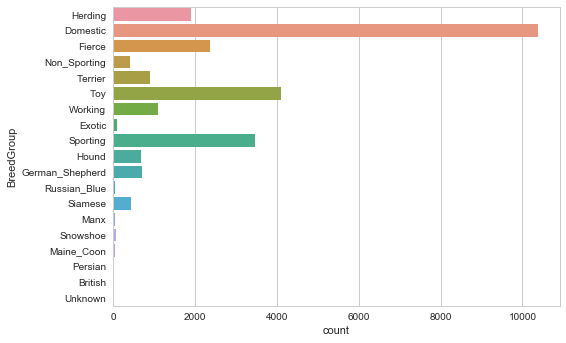

In [41]:

#feature_values_dog

train['BreedGroup'] = train.Breed.apply(BreedGroups)

pd.set_option('display.max_rows',1000) 
train['BreedGroup']
sns.countplot(data =train, y='BreedGroup')

In [42]:
train.groupby('BreedGroup').size()


BreedGroup
British                5
Domestic           10388
Exotic                85
Fierce              2367
German_Shepherd      704
Herding             1904
Hound                678
Maine_Coon            47
Manx                  49
Non_Sporting         399
Persian               16
Russian_Blue          36
Siamese              430
Snowshoe              78
Sporting            3459
Terrier              898
Toy                 4097
Unknown                2
Working             1087
dtype: int64

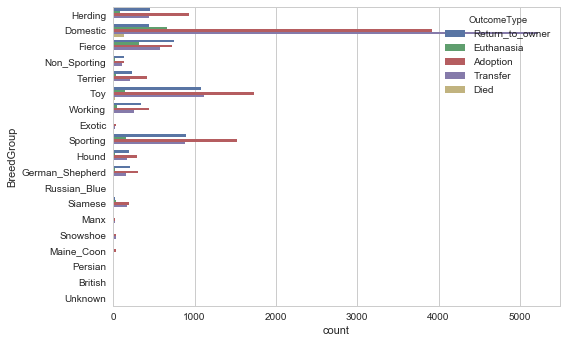

In [43]:
sns.countplot(data=train, y='BreedGroup',hue ="OutcomeType")

In [44]:
train[['Breed','OutcomeType','BreedGroup']].iloc[7000:8000]

,Breed,OutcomeType,BreedGroup
7000,Labrador Retriever Mix,Adoption,Sporting
7001,German Shepherd Mix,Adoption,German_Shepherd
7002,Domestic Shorthair Mix,Adoption,Domestic
7003,Domestic Shorthair Mix,Transfer,Domestic
7004,German Shepherd Mix,Transfer,German_Shepherd
7005,Domestic Shorthair Mix,Transfer,Domestic
7006,Domestic Longhair Mix,Return_to_owner,Domestic
7007,Domestic Shorthair Mix,Adoption,Domestic
7008,Labrador Retriever/Beagle,Adoption,Sporting
7009,Domestic Shorthair Mix,Adoption,Domestic


## Encoding : Label Encoding



### Name : 이름이 있으면1, 없으면 0으로 변환 
### AnimalType: Dog이면 1, Cat 이면 0로 변환 
### Sex: Male 이면 0, Female이면 1
### Neutered: 중성화 되어있으면 1, 안되어있으면 0 
### BreedGroup 종류에 따라 인코딩 필요 
### Mix: Pure Breed 면 1, Mix 면 0 


In [45]:
def Name(x):
    x= str(x)
    if x == 'Nan': return 'No'
    elif x =='nan': return 'No'
    elif x.lower() =='unknown': return 'No'
    else: return 'Yes'

In [46]:
train['NameExsist'] = train['Name'].apply(Name)
dfX= train.copy()
dfX

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Sex,Neutered,AgeInYears,AgeCategory,Mix,BreedGroup,NameExsist
0,A671945,Hambone,2014-02-12 18:22,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,Male,Neutered,1.0,young adult,Mix,Herding,Yes
1,A656520,Emily,2013-10-13 12:44,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,Female,Neutered,1.0,young adult,Mix,Domestic,Yes
2,A686464,Pearce,2015-01-31 12:28,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,Male,Neutered,2.0,young adult,Mix,Fierce,Yes
3,A683430,NaN,2014-07-11 19:09,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,Male,Intact,0.1,baby,Mix,Domestic,No
4,A667013,NaN,2013-11-15 12:52,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,Male,Neutered,2.0,young adult,Mix,Non_Sporting,No
5,A677334,Elsa,2014-04-25 13:04,Transfer,Partner,Dog,Intact Female,1 month,Cairn Terrier/Chihuahua Shorthair,Black/Tan,Female,Intact,0.5,cubs,Mix,Terrier,Yes
6,A699218,Jimmy,2015-03-28 13:11,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Tabby,Male,Intact,0.1,baby,Mix,Domestic,Yes
7,A701489,NaN,2015-04-30 17:02,Transfer,Partner,Cat,Unknown,3 weeks,Domestic Shorthair Mix,Brown Tabby,Female,Intact,0.1,baby,Mix,Domestic,No
8,A671784,Lucy,2014-02-04 17:17,Adoption,NaN,Dog,Spayed Female,5 months,American Pit Bull Terrier Mix,Red/White,Female,Neutered,0.5,cubs,Mix,Fierce,Yes
9,A677747,NaN,2014-05-03 7:48,Adoption,Offsite,Dog,Spayed Female,1 year,Cairn Terrier,White,Female,Neutered,1.0,young adult,Pure Breed,Terrier,No


In [47]:
from sklearn.preprocessing import LabelEncoder
dfX['NameExsist'] = LabelEncoder().fit_transform(dfX['NameExsist'])
dfX['DateTime'] = LabelEncoder().fit_transform(dfX['DateTime'])
dfX['AnimalType'] = LabelEncoder().fit_transform(dfX["AnimalType"])
dfX['Sex'] = LabelEncoder().fit_transform(dfX["Sex"])
dfX['Neutered'] = LabelEncoder().fit_transform(dfX['Neutered'])
dfX['AgeInYears'] = LabelEncoder().fit_transform(dfX['AgeInYears'])
dfX["Breed"] = LabelEncoder().fit_transform(dfX["Breed"])
dfX['Mix'] = LabelEncoder().fit_transform(dfX['Mix'])
dfX['Color'] = LabelEncoder().fit_transform(dfX['Color'])
dfX["BreedGroup"] = LabelEncoder().fit_transform(dfX["BreedGroup"])
dfX["OutcomeType"] = LabelEncoder().fit_transform(dfX["OutcomeType"])
dfX.head()

#dfX[['NameExsist', 'DateTime','AnimalType', 'Color','Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup']]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Sex,Neutered,AgeInYears,AgeCategory,Mix,BreedGroup,NameExsist
0,A671945,Hambone,3361,3,NaN,1,Neutered Male,1 year,1221,130,1,1,2,young adult,0,5,1
1,A656520,Emily,350,2,Suffering,0,Spayed Female,1 year,640,167,0,1,2,young adult,0,1,1
2,A686464,Pearce,12680,0,Foster,1,Neutered Male,2 years,1066,86,1,1,3,young adult,0,3,1
3,A683430,NaN,7187,4,Partner,0,Intact Male,3 weeks,640,42,1,0,0,baby,0,1,0
4,A667013,NaN,1233,4,Partner,1,Neutered Male,2 years,914,274,1,1,3,young adult,0,9,0


## Feature Selection 

In [48]:
dfX

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Sex,Neutered,AgeInYears,AgeCategory,Mix,BreedGroup,NameExsist
0,A671945,Hambone,3361,3,NaN,1,Neutered Male,1 year,1221,130,1,1,2,young adult,0,5,1
1,A656520,Emily,350,2,Suffering,0,Spayed Female,1 year,640,167,0,1,2,young adult,0,1,1
2,A686464,Pearce,12680,0,Foster,1,Neutered Male,2 years,1066,86,1,1,3,young adult,0,3,1
3,A683430,NaN,7187,4,Partner,0,Intact Male,3 weeks,640,42,1,0,0,baby,0,1,0
4,A667013,NaN,1233,4,Partner,1,Neutered Male,2 years,914,274,1,1,3,young adult,0,9,0
5,A677334,Elsa,5020,4,Partner,1,Intact Female,1 month,369,36,0,0,1,cubs,0,15,1
6,A699218,Jimmy,13870,4,Partner,0,Intact Male,3 weeks,640,63,1,0,0,baby,0,1,1
7,A701489,NaN,14616,4,Partner,0,Unknown,3 weeks,640,104,0,0,0,baby,0,1,0
8,A671784,Lucy,3213,0,NaN,1,Spayed Female,5 months,45,250,0,1,1,cubs,0,3,1
9,A677747,NaN,5228,0,Offsite,1,Spayed Female,1 year,364,318,0,1,2,young adult,1,15,0


In [49]:
## 독립변수 X 와 종속 변수 y 분류 

## Animal ID 제거: key 값 
## OutcomeSubType 제거: test 파일에는 OutcomeSubType feature 없음
## sexuponoutcome 은 Sex와 Neutered feature로 대체
## Mix type 추가 (필요없을시 삭제 예정)
## AgeuponOutcome 은 AgeInYears로 대체 
## AgeCategory는 AgeInYears를 바탕으로 만들었으므로 상관성 높음: 삭제 
## Breed는 Breed Group으로 대체 


X = dfX[['NameExsist', 'DateTime','AnimalType', 'Color',
       'Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup','Breed']]
y = dfX['OutcomeType']

Feature ranking:
1. feature 1 (0.313032)
2. feature 3 (0.158456)
3. feature 6 (0.147234)
4. feature 5 (0.146680)
5. feature 9 (0.100420)
6. feature 0 (0.048494)
7. feature 8 (0.044870)
8. feature 2 (0.024124)
9. feature 4 (0.010530)
10. feature 7 (0.006161)


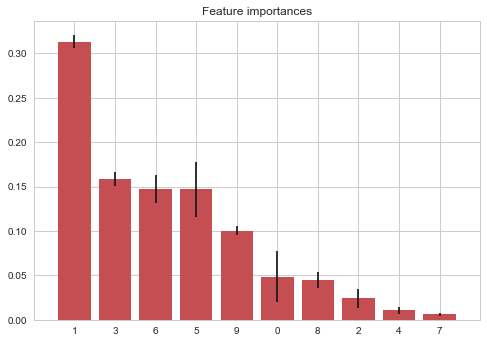

In [50]:
## 의사결정나무를 통한 feature Importance 구하기 
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier ## 랜덤포레스트

forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
forest.fit(X, y)

importances = forest.feature_importances_

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

#dfX[['NameExsist', 'DateTime','AnimalType', 'Color','Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup',''Breed']]

In [51]:
## Lasso 회귀 Feature Importance 구하기 

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))
    
df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso

,0.001,0.01,0.1,1.0,10.0
0,3.254249,3.245046,2.969231,2.110993,2.156451
1,-0.309721,-0.256289,-0.000000,-0.000000,-0.000000
2,-0.000004,-0.000004,-0.000006,-0.000008,-0.000008
3,0.165753,0.070611,-0.000000,-0.000000,-0.000000
4,0.000177,0.000176,0.000106,-0.000155,-0.000000
5,0.064829,0.028691,0.000000,-0.000000,-0.000000
6,-1.962079,-1.926459,-1.559122,-0.000000,-0.000000
7,0.091427,0.090471,0.062252,0.000000,0.000000
8,0.177206,0.000000,0.000000,0.000000,0.000000
9,-0.006829,-0.001860,-0.002028,-0.000000,-0.000000


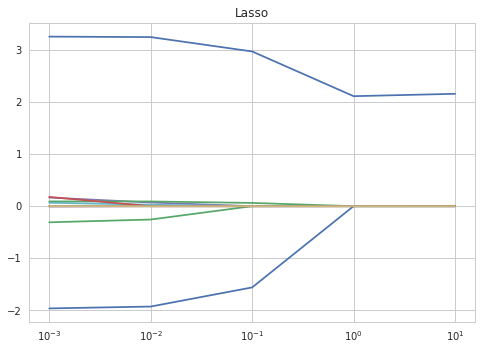

In [52]:
mpl.rcParams["font.family"] = 'DejaVu Sans'


plt.semilogx(df_lasso.T)
plt.xticks(alpha)
plt.title("Lasso")
plt.show() ##여기서는 Breed 보다 BreedGroup이 성능이 더 좋음, 나머지는 의사결정나무와 같은 결과

In [53]:
## XGBoost 사용

import xgboost
model_xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)
%time
model_xgb.fit(X, y)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Wall time: 0 ns


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

## 교차검증을 통한 성능비교 

In [56]:
X = dfX[['NameExsist','AnimalType',
       'Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup']]
y = dfX['OutcomeType']
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20)

forest = ExtraTreesClassifier(n_estimators=5)
#xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

print(cross_val_score(forest, X, y, scoring="neg_log_loss", cv=cv)*-1)
print(cross_val_score(forest, X, y, scoring="neg_log_loss", cv=cv).mean()*-1)##7.37975130902 ## Datetime과 color 삭제안한경우 
print(cross_val_score(forest, X, y, scoring="neg_log_loss", cv=cv).std())

[ 2.01495136  1.79521798  1.97459773  2.1730599   2.29160167  2.09404137
  1.80612699  1.92732944  2.41942239  1.81739981  1.87452429  2.01673216
  2.2190647   2.11953034  2.14719634  2.04076692  1.86713353  2.46890533
  1.74327397  2.14900698]
2.03983020472
0.18534938279


X = dfX[['NameExsist','AnimalType','Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup']] 
y = dfX['OutcomeType']

##Datetime과 color 삭제한경우 
##2.03983020472

In [57]:
X = dfX[['NameExsist','AnimalType',
       'Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup']]
y = dfX['OutcomeType']
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(20)

#forest = ExtraTreesClassifier(n_estimators=5)
xgb = xgboost.XGBClassifier(n_estimators=100, max_depth=2)

print(cross_val_score(xgb, X, y, scoring="neg_log_loss", cv=cv)*-1)
print(cross_val_score(xgb, X, y, scoring="neg_log_loss", cv=cv).mean()*-1)##0.863588623826 ## Datetime과 color 삭제안한경우 
print(cross_val_score(xgb, X, y, scoring="neg_log_loss", cv=cv).std())

[ 0.87030194  0.85271767  0.8537233   0.85794778  0.90124361  0.87590298
  0.84947052  0.86716389  0.86974766  0.84474099  0.88239841  0.87362426
  0.88570503  0.88976916  0.83760907  0.85968864  0.84466718  0.87488721
  0.82858954  0.88120279]
0.865055082063
0.0183906094085


In [ ]:
X = dfX[['NameExsist','AnimalType','Sex', 'Neutered', 'AgeInYears','Mix', 'BreedGroup']] 
y = dfX['OutcomeType']
## Datetime과 color 삭제한경우 
##0.865055082063